# TelecoX Churn Exploratory Data Analysis

TelecoX  is  a  national  telecommunication  company  that  is  facing  an  increasing  churning 
problem due to the privatization of the market. 
 
In order to mitigate this issue, the head of the marketing department is aiming to offer a 20% 
discount for customers who are likely to churn. Hence it important to predict accurately the 
propensity of churn of each customer while reducing the number of false positive. 

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

import sys
sys.path.append('../lib')

from config import RED, BLUE

plt.style.use('seaborn-v0_8-pastel')

plt.rc('legend',fontsize=20, title_fontsize=20) # using a size in points

In [3]:
# Some Useful Functions

def plot_corr(df, method='Pearson', thres=.25):
    '''
    Specific plots related to correlations.

    Input: DataFrame object with variables as index and a column called Correlations
    '''

    df_aux = df.copy()
    df_aux['thres'] = (df_aux['Correlations'].abs() > 0.25).apply(lambda x: f'Above {thres}' if x else f'Below {thres}')

    fig, ax = plt.subplots(figsize=(50, 30))
    sns.barplot(df_aux, y=df_aux.index, x='Correlations', hue='thres', 
                orient='horizontal', palette={f'Above {thres}': RED, f'Below {thres}':BLUE},
                ax=ax)
    ax.tick_params(axis='both', labelsize=30, rotation=0)
    ax.set_title(f'Top {method} Correlations\n', fontsize=50)
    ax.legend(loc=(.7, .6), fontsize=60)
    fig.tight_layout()
    return fig, ax

def cramersv(df, x, y):
    '''
    Calculates Cramer's V param between 2 categorical columns from a dataframe 
    '''
    # Finding Chi-squared test statistic,
    # sample size, and minimum of rows
    # and columns
    dataset = df[[x, y]].copy()
    dataset = dataset.groupby([x, y]).size().unstack()
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset.values)
    minimum_dimension = min(dataset.shape)-1
    
    # Calculate Cramer's V
    result = np.sqrt((X2/N) / minimum_dimension)
    
    # Print the result
    return result


## Read Data

- Read train data for EDA. We want to find the most important features for our model.

Variables:

- **Gender**: Whether the customer is a male or a female 
- **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0) 
- **Partner**: Whether the customer has a partner or not (Yes, No) 
- **Dependents**: Whether the customer has dependents or not (Yes, No) 
- **tenure**: Number of months the customer has stayed with the company 
- **PhoneService**: Whether the customer has a phone service or not (Yes, No) 
- **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service) 
- **InternetService**: Customer’s internet service provider (DSL, Fiber optic, No) 
- **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet 
service) 
- **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet 
service) 
- **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet 
service) 
- **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service) 
- **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)  
- **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No 
internet service) 
- **Contract**: The contract term of the customer (Month-to-month, One year, Two year) 
- **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No) 
- **PaymentMethod**: The customer’s payment method (Electronic check, Mailed check, Bank 
transfer (automatic), Credit card (automatic)) 
- **MonthlyCharges**: The amount charged to the customer monthly 
- **TotalCharges**: The total amount charged to the customer 
- **Churn**: Whether the customer churned or not (Yes or No) 

In [4]:
path = '../data/train.csv'
df_orig = pd.read_csv(path)
df = df_orig.copy() # Copy for future manipulations
df_orig.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,11,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,102.00,1145.35,Yes
1,Male,0,Yes,Yes,66,Yes,Yes,DSL,No,No,Yes,No,Yes,No,Two year,Yes,Bank transfer (automatic),NaN,4189.7,No
2,Male,0,Yes,Yes,71,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.45,1378.45,No
3,Female,0,Yes,No,31,Yes,No,DSL,Yes,No,No,Yes,No,Yes,One year,Yes,Electronic check,64.00,1910.75,No
4,Male,0,Yes,Yes,62,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,NaN,5215.25,No
5,Male,0,Yes,Yes,32,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,18.95,613.95,No
6,Male,0,Yes,Yes,67,Yes,No,DSL,Yes,Yes,No,No,No,No,Two year,Yes,Bank transfer (automatic),54.20,3838.2,No
7,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Credit card (automatic),NaN,4748.7,No
8,Female,0,Yes,Yes,8,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.85,146.6,No
9,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.55,80.55,No


# Exploratory Data Analysis

Before training any model, it is important to explore the content of our data so that we can find interesting patterns that can help us to improve model quality.

## Shape and type of the Data

In [5]:
print("In this dataset we can find {} rows and {} columns".format(*df.shape))

In this dataset we can find 4212 rows and 20 columns


Most of the variables are categorical except `tenure`, `Monthly Charges` and `Total Charges`.

In [6]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

The type of Total Charges is `object`. Using regular expressions we can check if there is something different from a number or digit. Doing this we can see that there are missing values introduced like whitespaces. Let's substitute them by `np.nan` so that we can cast the column into float type.

In [7]:
df[df['TotalCharges'].apply(lambda x: bool(re.match('\D+', x)))] 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
31,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
176,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
298,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
1736,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
2194,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
2895,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
2944,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3230,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),NaN,,No


In [8]:
empty_val = df[df['TotalCharges'].apply(lambda x: bool(re.match('\D+', x)))]['TotalCharges'].unique()[0]
empty_val

' '

In [9]:
df.loc[df['TotalCharges']==empty_val, ['TotalCharges']] = np.nan
df['TotalCharges'] = df['TotalCharges'].astype(float)
df.dtypes['TotalCharges']

dtype('float64')

In [10]:
num_data = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_data = [col for col in df.columns if col not in num_data]

print('Numeric Vars:\n',num_data, '\n')
print('Categoric Vars:\n',cat_data)

Numeric Vars:
 ['tenure', 'MonthlyCharges', 'TotalCharges'] 

Categoric Vars:
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


## Missing Values

The two only variables with missing values are the Monthly Charges and Total Chrages. The amount of data without these values is enough to not to drop them. Different strategies for data imputation will be explored later on.

In the case of missing values in `Total Charges` they correspond to customers who have 0 months of `tenure`. In these cases, we can fill the Total Charges with the Month Charges. In the case of the one who hasn't paid anything yet, we can fill both values with 0.

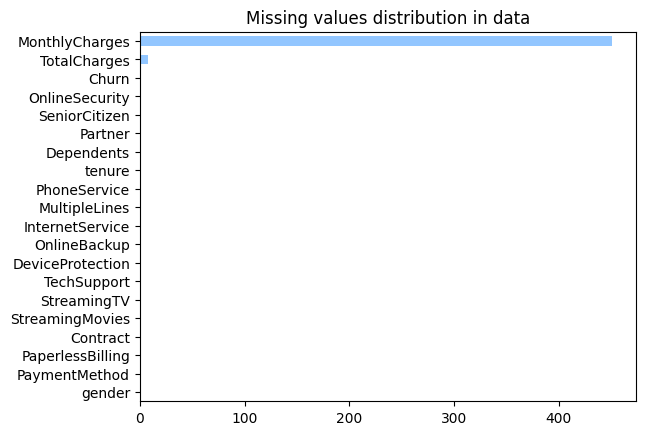

In [11]:
df.isnull().sum().sort_values().plot(kind='barh', title='Missing values distribution in data');


In [12]:
df[df['TotalCharges'].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
31,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
176,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
298,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
1736,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
2194,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
2895,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
2944,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
3230,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),NaN,NaN,No


In [13]:
df[df['MonthlyCharges'].isnull()].head(20)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1,Male,0,Yes,Yes,66,Yes,Yes,DSL,No,No,Yes,No,Yes,No,Two year,Yes,Bank transfer (automatic),NaN,4189.70,No
4,Male,0,Yes,Yes,62,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,NaN,5215.25,No
7,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,One year,Yes,Credit card (automatic),NaN,4748.70,No
14,Female,1,No,No,7,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,NaN,574.35,No
24,Female,0,No,No,2,Yes,No,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,NaN,137.10,No
33,Female,1,Yes,No,66,No,No phone service,DSL,No,Yes,Yes,No,Yes,No,One year,No,Bank transfer (automatic),NaN,3027.25,No
38,Male,0,No,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,229.55,Yes
47,Male,0,No,No,33,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,No,Two year,Yes,Electronic check,NaN,3027.65,No
57,Female,0,No,No,23,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),NaN,1758.60,Yes
68,Female,0,Yes,No,7,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),NaN,496.90,Yes


Let's fill the values for `MonthlyCharges` as mentioned before.

In [14]:
df['MonthlyCharges'] = df['MonthlyCharges'].fillna(0)
df.loc[df['TotalCharges'].isnull()&(df['MonthlyCharges']==0), ['TotalCharges']] = 0

We can impute Missing Monthly Charges using Total Charges / tenure. In the following plot we can appreciate the different slopes for each of the tenures.  

<AxesSubplot: xlabel='MonthlyCharges', ylabel='TotalCharges'>

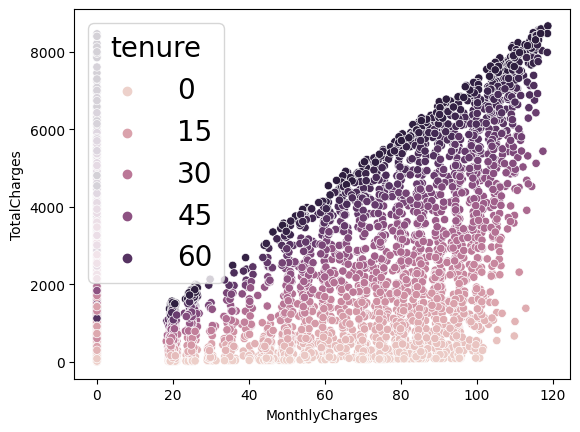

In [15]:
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='tenure', data=df)

## Categoric Data Analysis

In [16]:
df_cat = df.copy()
df_cat = df_cat[cat_data]

First of all, let's display the number of different categories for each of them. We can see that they don't take too many different values so it  is possible to track the influence of each of them in the target.

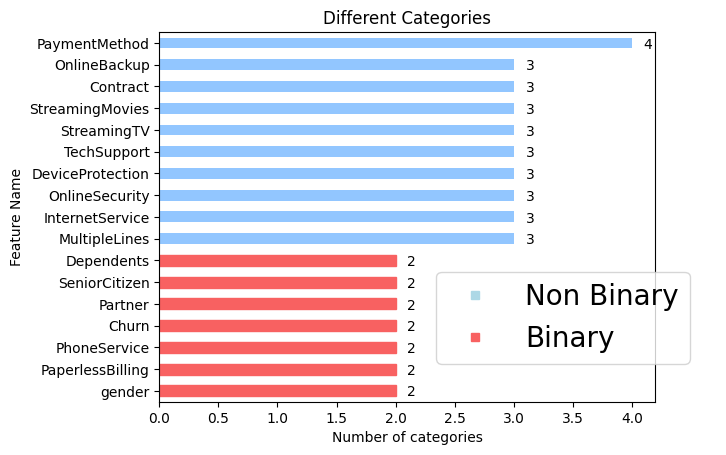

In [17]:
sr_cat_unique = df_cat.apply(lambda x: x.nunique()).sort_values()

fig, ax = plt.subplots()
bars = sr_cat_unique.plot(kind='barh', ax=ax, title='Different Categories')

ax.plot([], [], 's', color=BLUE, fillstyle='full', label='Non Binary')
ax.plot([], [], 's', color=RED, fillstyle='full', label='Binary')

for bar in bars.patches:
    ax.text(bar.get_width() + .1,  bar.get_y(), bar.get_width())
    if bar.get_width() == 2:
        bar.set_color(RED)

ax.set_xlabel('Number of categories')
ax.set_ylabel('Feature Name')
fig.legend(loc=(0.6, 0.2))


### Binary Variables


In this subsection we can see that the **gender of the person or if they have hired a Phone Service or not doesn't influence the churn**, or at least, not in a direct way. 

However, we can see that having dependents, being senior, having a partner and having paperless billing or not, have a  significative effect on churn.

Risk of churn factors:

- Not having paper billing (related to young people)
- Not having a Partner
- Not being Senior
- Not having Dependents


In [18]:
cols_binary = list(sr_cat_unique[sr_cat_unique == 2].index)
df_binary = df.copy()
df_binary = df_binary[cols_binary]

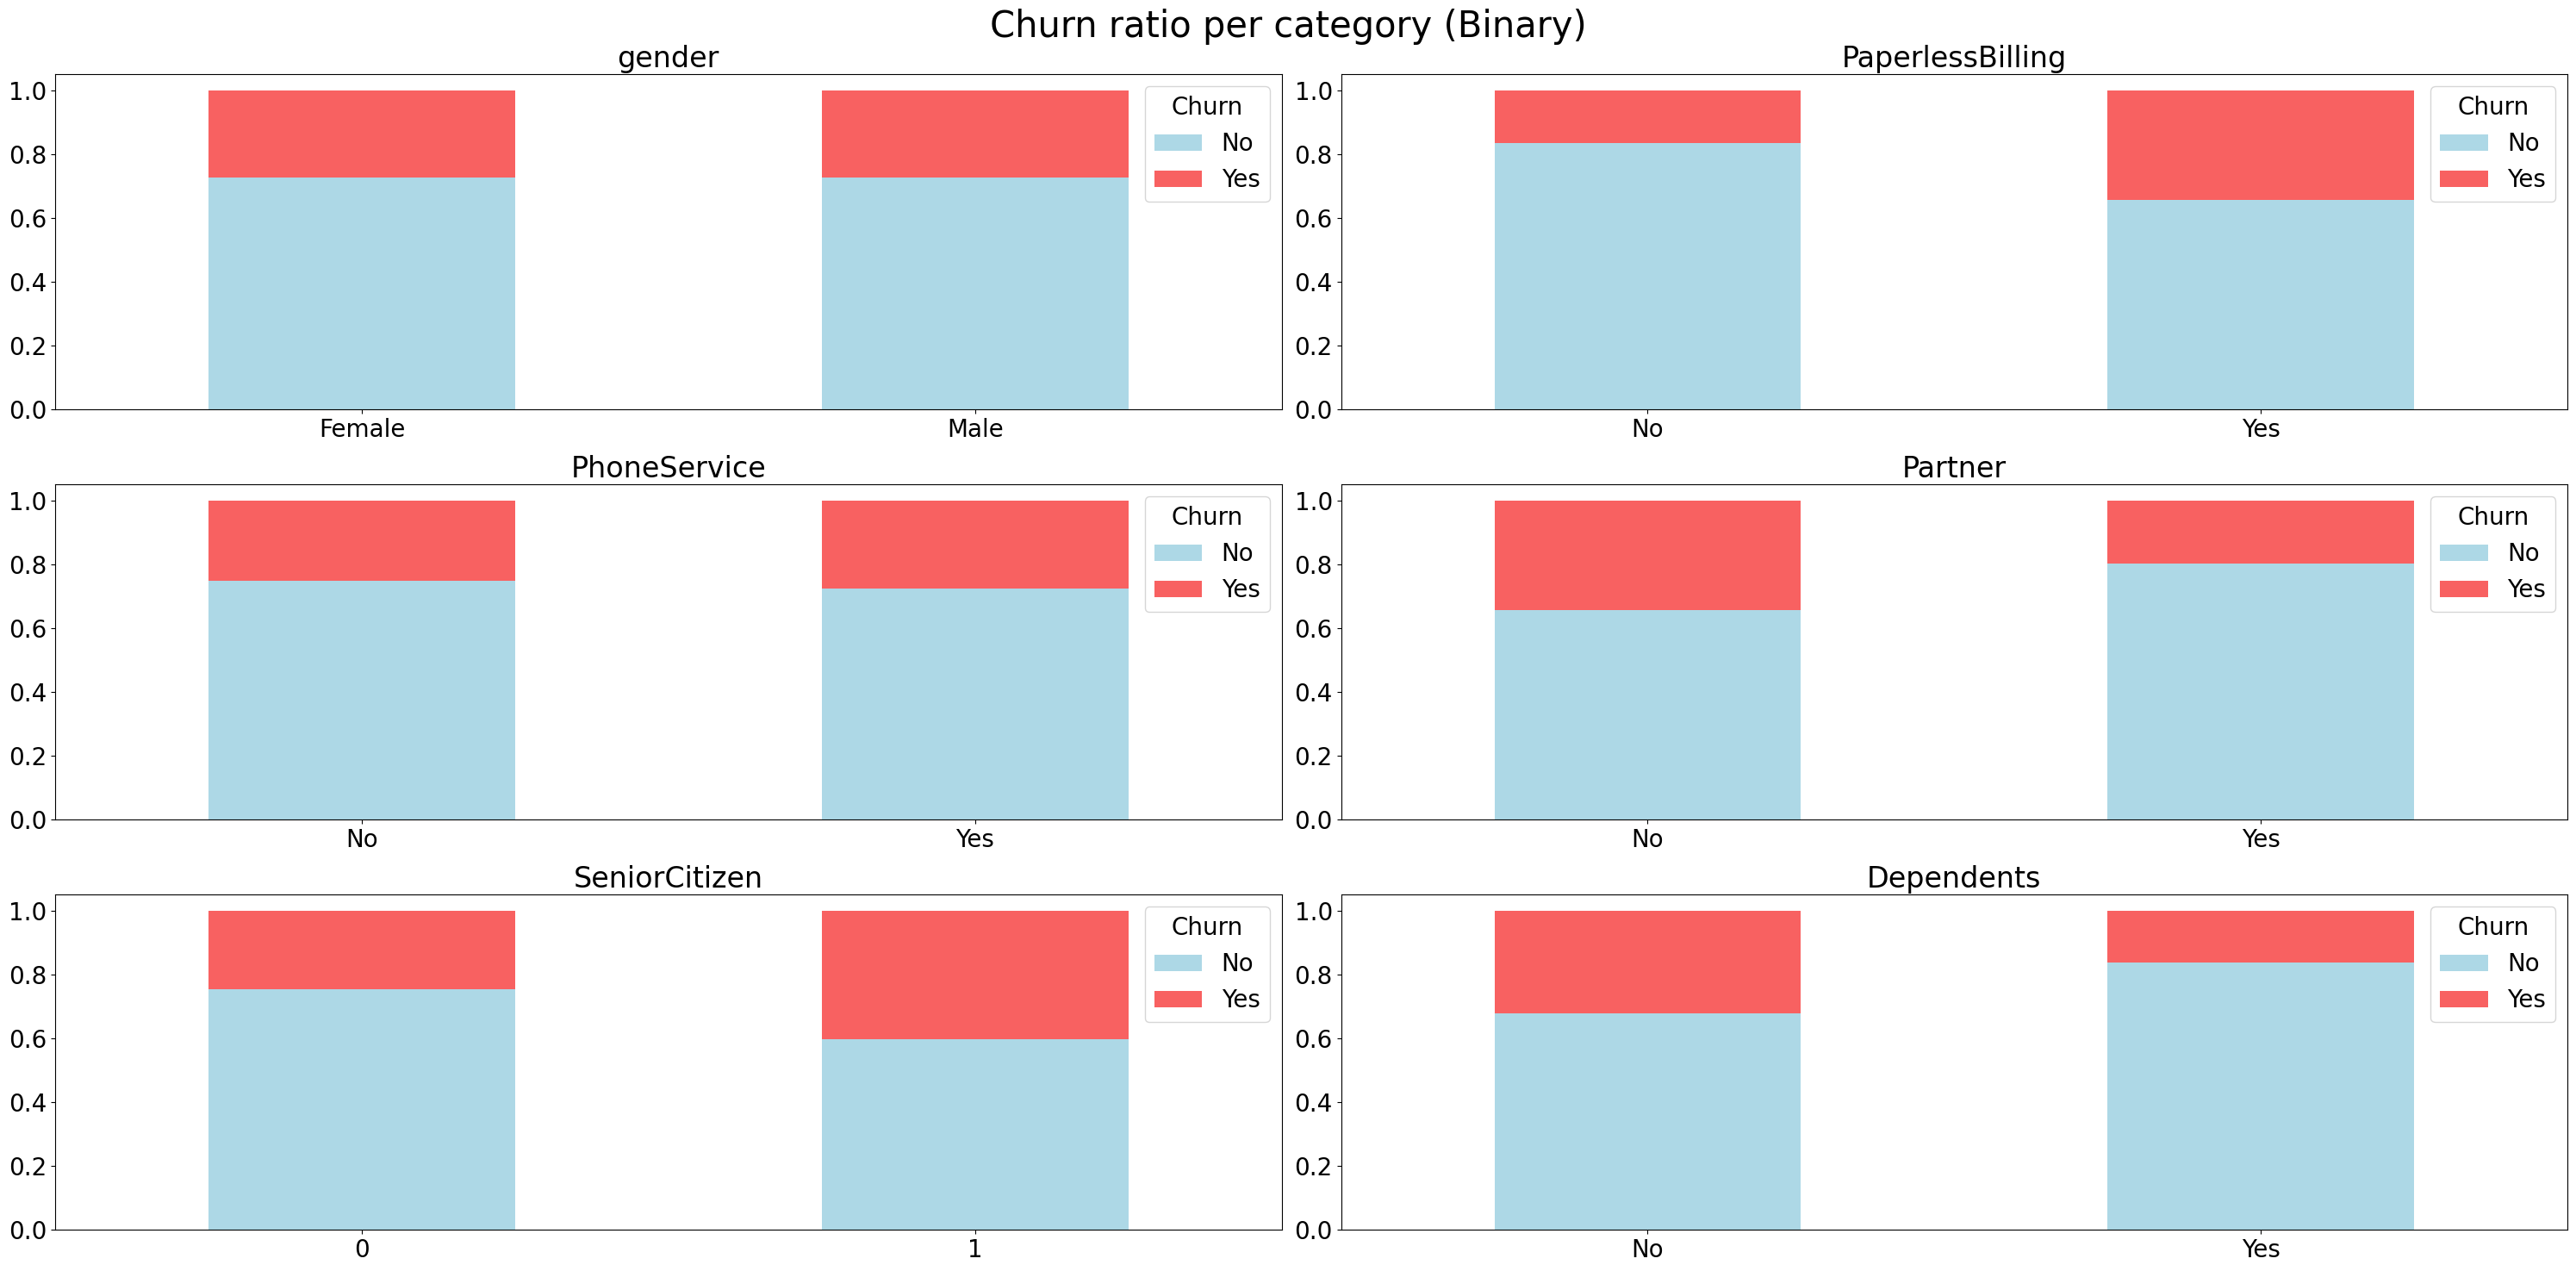

In [19]:
cols_binary = [x for x in cols_binary if 'Churn' != x]
fig, ax = plt.subplots(len(cols_binary) // 2, 2, figsize=(30, 15))
ax = ax.reshape(-1)
for i, col in enumerate(cols_binary):
    df_binary_prop = df_binary.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    df_binary_prop.plot(kind='bar', stacked=True, ax=ax[i], title=col, color=[BLUE, RED])
    
    ax[i].set_xlabel('')
    ax[i].set_title(col, fontsize=24)
    ax[i].tick_params(axis='both', labelsize=20, rotation=0)

# fig.subplots_adjust()
fig.suptitle("Churn ratio per category (Binary)", fontsize=30)
fig.tight_layout()

At first glance, it is possible to observe that `gender` and `PhoneService`, when treated individually, aren't decisive in Churn predictions.

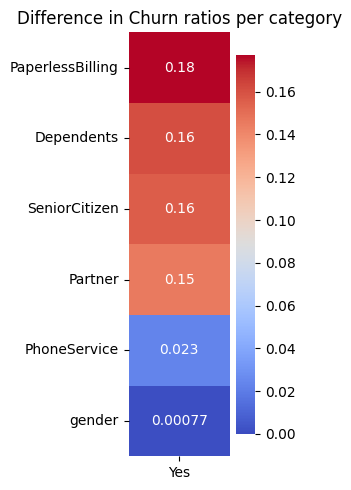

In [20]:
df_churn = df_binary.melt(value_vars=cols_binary, id_vars='Churn').\
                    groupby(['variable', 'value'])['Churn'].\
                    value_counts(normalize=True).\
                    unstack(level=2).\
                    reset_index()

dff = pd.DataFrame(df_churn.groupby('variable')['Yes'].diff().dropna().abs())
dff.index = df_churn['variable'].unique()

fig, ax = plt.subplots(figsize=(3, 5))
sns.heatmap(dff.sort_values(by='Yes', ascending=False), vmin=0, ax=ax, annot=True, cmap='coolwarm')
ax.set_title('Difference in Churn ratios per category')
fig.tight_layout();

In [21]:
df_bin_dummy = pd.get_dummies(df_binary, drop_first=True)
df_bin_dummy.columns=[re.sub('_.*$', '', col) for col in df_bin_dummy]
df_bin_dummy

,SeniorCitizen,gender,PaperlessBilling,PhoneService,Churn,Partner,Dependents
0,0,0,1,1,1,1,0
1,0,1,1,1,0,1,1
2,0,1,0,1,0,1,1
3,0,0,1,1,0,1,0
4,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...
4207,0,0,0,1,0,1,1
4208,0,0,1,1,0,0,0
4209,0,1,1,1,0,0,0
4210,0,0,1,1,1,0,0


In [22]:
def cramersv(df, x, y):
    
    # Finding Chi-squared test statistic,
    # sample size, and minimum of rows
    # and columns
    dataset = df_binary[[x, y]].copy()
    dataset = dataset.groupby([x, y]).size().unstack()
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    N = np.sum(dataset.values)
    minimum_dimension = min(dataset.shape)-1
    
    # Calculate Cramer's V
    result = np.sqrt((X2/N) / minimum_dimension)
    
    # Print the result
    return result

In [23]:
d_cramer = {}
for col in cols_binary:
    d_cramer[col] = [cramersv(df_bin_dummy, 'Churn', col)]

pd.DataFrame.from_dict(d_cramer)

,gender,PaperlessBilling,PhoneService,Partner,SeniorCitizen,Dependents
0,0.000866,0.195092,0.015068,0.163311,0.130071,0.166864


### Non Binary Variables

In this case, we can easily see in the plots that 3 important factors in churn are the following:

- Having Fiber Optic as Internet Service
- Not having Online Security, Device Protection or Tech Support
- Having Month-to-month contracts instead  of 1year or 2year
- Using Electroonic Check as Payment Method


In [24]:
cols_non_binary = list(sr_cat_unique[sr_cat_unique > 2].index)
df_non_binary = df.copy()
df_non_binary = df_non_binary[cols_non_binary + ['Churn']]

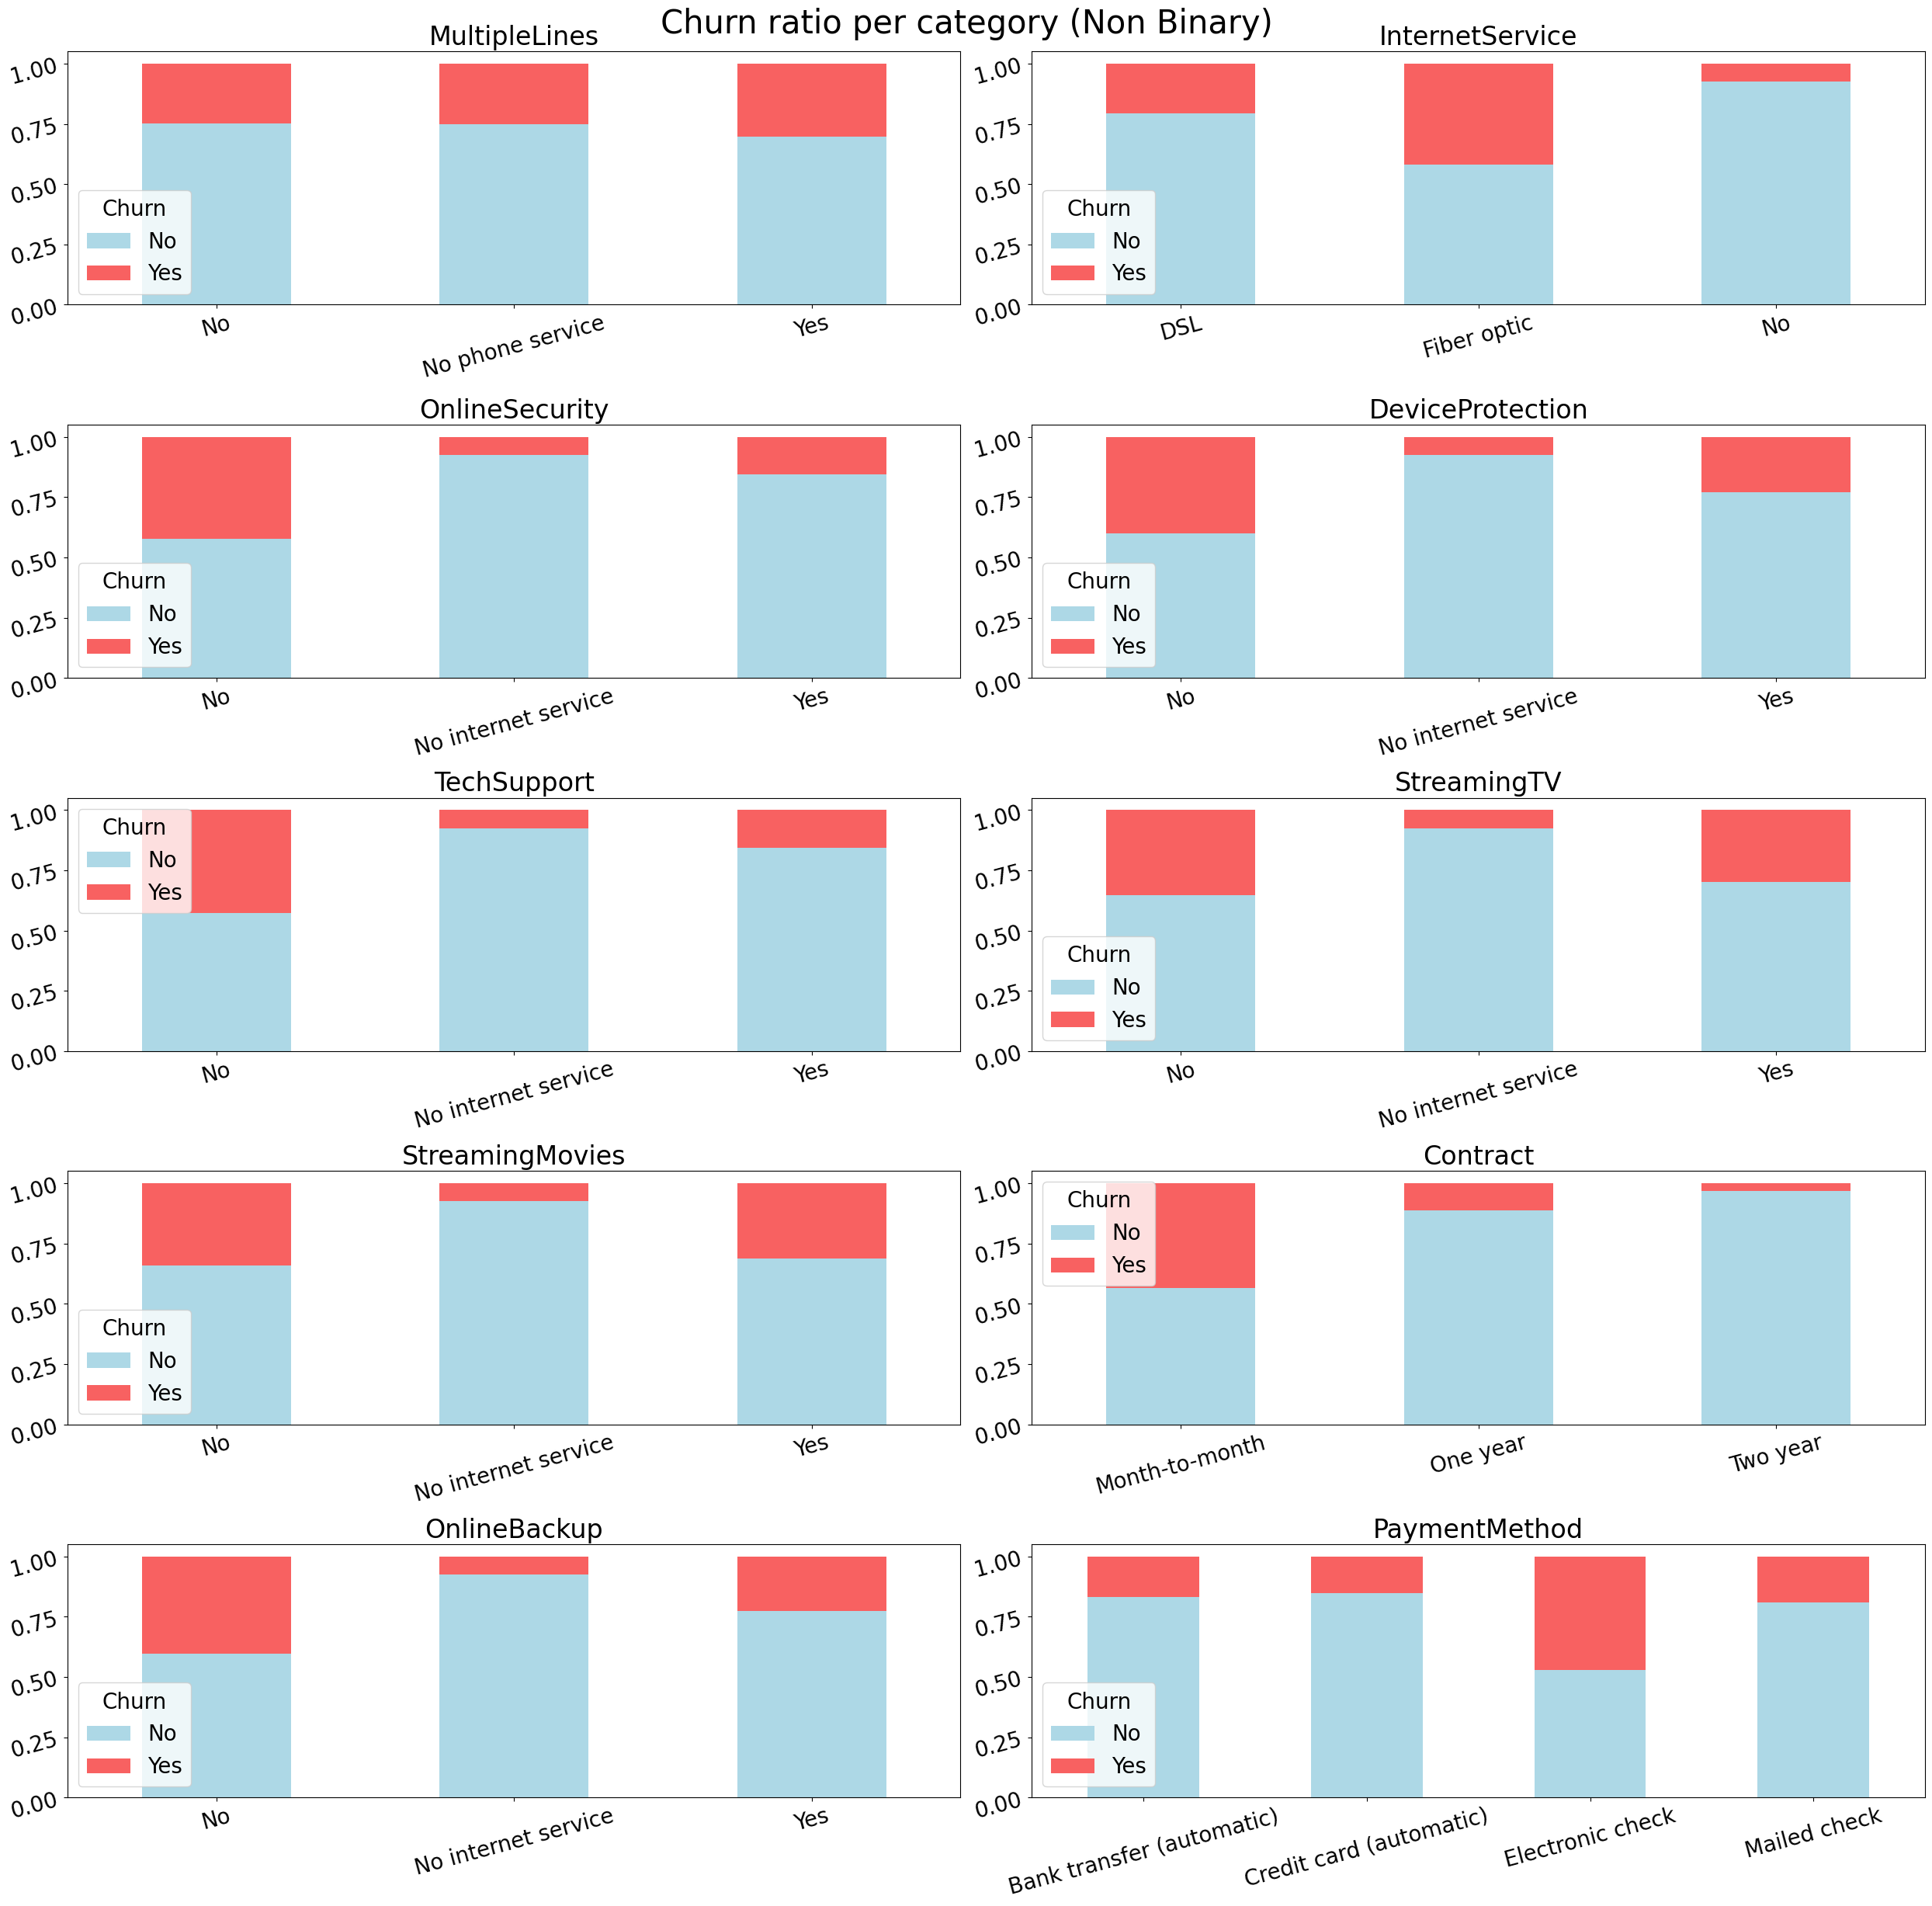

In [82]:
cols_non_binary_ = [x for x in cols_non_binary if 'Churn' != x]
fig, ax = plt.subplots(len(cols_non_binary_) // 2 , 2, figsize=(25, 25))
ax = ax.reshape(-1)
for i, col in enumerate(cols_non_binary_):
    df_non_binary_prop = df_non_binary.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    df_non_binary_prop.plot(kind='bar', stacked=True, ax=ax[i], title=col, color=[BLUE, RED])
    
    ax[i].set_xlabel('')
    ax[i].set_title(col, fontsize=24)
    ax[i].tick_params(axis='both', labelsize=20, rotation=15)

# fig.subplots_adjust()
fig.suptitle("Churn ratio per category (Non Binary)", fontsize=30)
fig.tight_layout()

#### Non binary (No Internet Service)

For those with three categories but one of them being 'No internet service' we can consider the mentioned as 'No' and calculate the same metrics.

In [56]:
cols_no_int

['MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

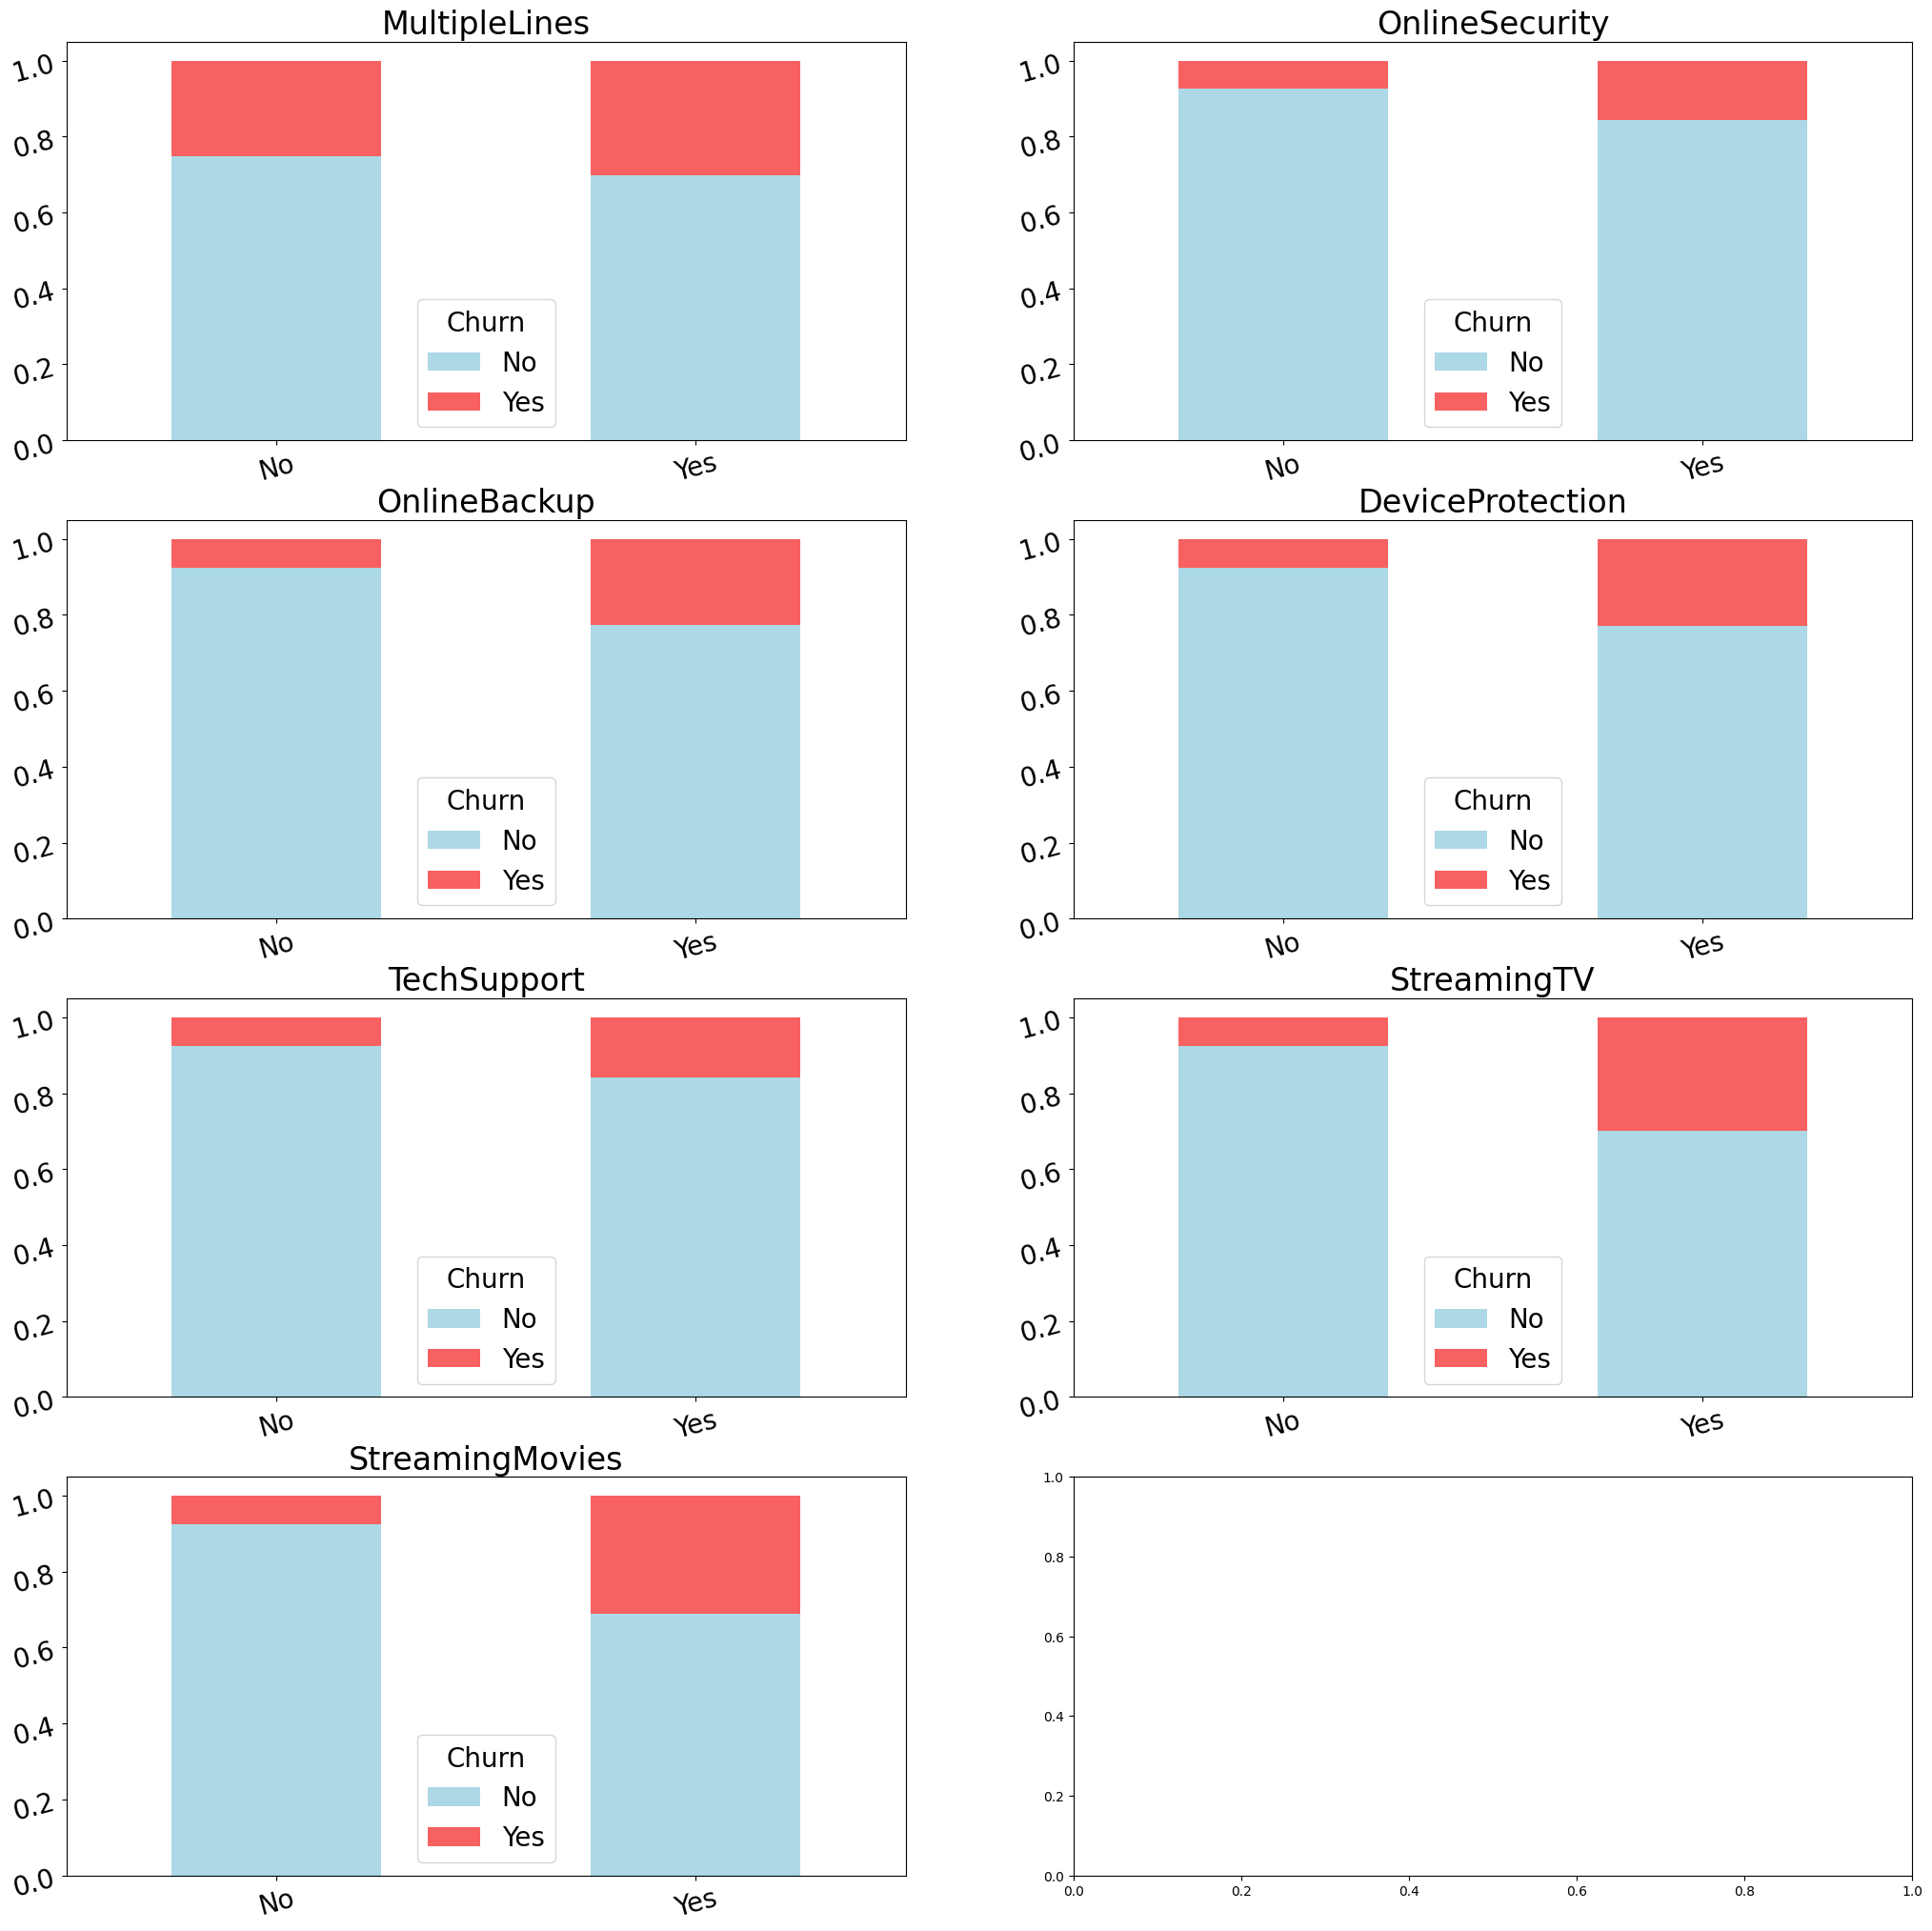

In [83]:
dff = df.copy()
cols_no_int = list(dff[dff.isin(['No internet service', 'No phone service'])].dropna(axis=1, how='all').columns)
dff[cols_no_int] = dff.loc[:, cols_no_int].apply(lambda col: col.map({'Yes':'Yes', 'No phone service':'No', 'No internet service':'No'}))

fig, ax = plt.subplots(len(cols_no_int) // 2 +1 , 2, figsize=(25, 25))
ax = ax.reshape(-1)
for i, col in enumerate(cols_no_int):
    df_non_binary_prop = dff.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    df_non_binary_prop.plot(kind='bar', stacked=True, ax=ax[i], title=col, color=[BLUE, RED])
    
    ax[i].set_xlabel('')
    ax[i].set_title(col, fontsize=24)
    ax[i].tick_params(axis='both', labelsize=20, rotation=15)

In [58]:
df_churn

Churn,variable,value,No,Yes
0,DeviceProtection,No,0.925028,0.074972
1,DeviceProtection,Yes,0.771228,0.228772
2,OnlineBackup,No,0.925028,0.074972
3,OnlineBackup,Yes,0.774462,0.225538
4,OnlineSecurity,No,0.925028,0.074972
5,OnlineSecurity,Yes,0.843333,0.156667
6,StreamingMovies,No,0.925028,0.074972
7,StreamingMovies,Yes,0.688113,0.311887
8,StreamingTV,No,0.925028,0.074972
9,StreamingTV,Yes,0.700430,0.299570


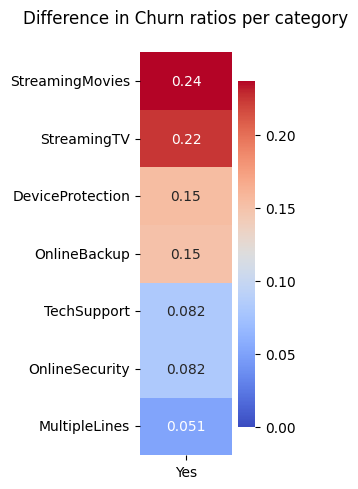

In [84]:
df_churn = dff.melt(value_vars=cols_no_int, id_vars='Churn').\
                    groupby(['variable', 'value'])['Churn'].\
                    value_counts(normalize=True).\
                    unstack(level=2).\
                    reset_index()

dff = pd.DataFrame(df_churn.groupby('variable')['Yes'].diff().dropna().abs())
dff.index = df_churn['variable'].unique()

fig, ax = plt.subplots(figsize=(3, 5))
sns.heatmap(dff.sort_values(by='Yes', ascending=False), vmin=0, ax=ax, annot=True, cmap='coolwarm')
ax.set_title('Difference in Churn ratios per category\n')
fig.tight_layout();

#### MultiCategory

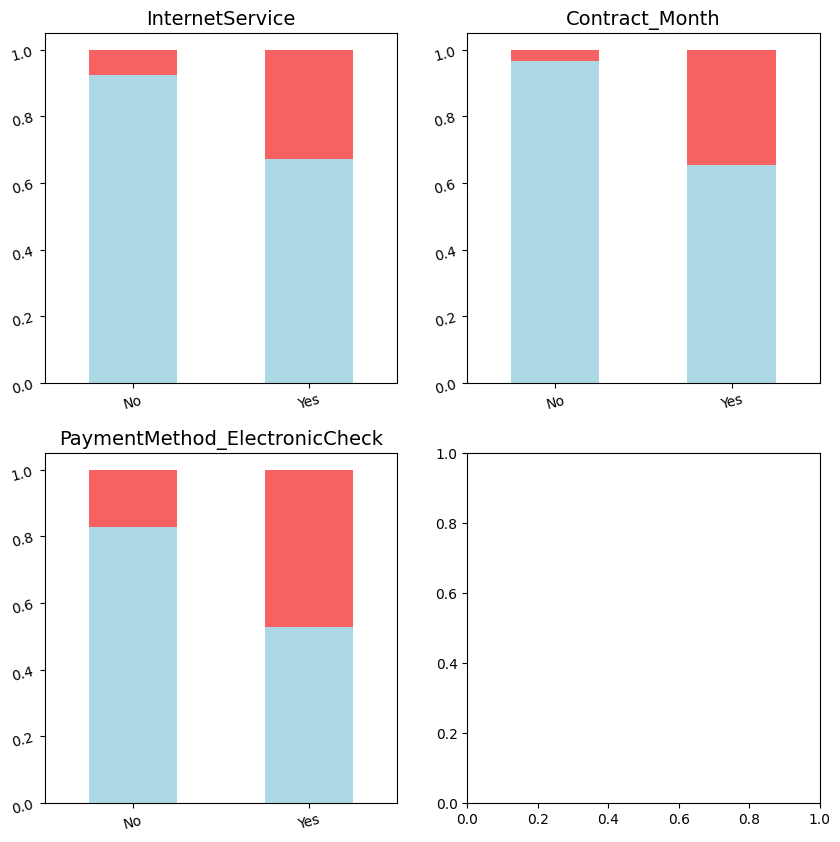

In [87]:
cols_multi = ['InternetService', 'Contract', 'PaymentMethod', 'Churn']
dff = df.copy()
dff = dff[cols_multi]

dff['InternetService'] = dff['InternetService'].map({'DSL':'Yes', 'Fiber optic':'Yes', 'No':'No'}) 
dff['Contract_Month'] = dff['Contract'].map({'Month-to-month':'Yes', 'One year':'Yes', 'Two year':'No'})
dff['PaymentMethod_ElectronicCheck'] = dff['PaymentMethod'].map({'Electronic check':'Yes', 
                                                                    'Bank transfer (automatic)':'No', 
                                                                    'Mailed check':'No',
                                                                    'Credit card (automatic)':'No'})

cols_multi = ['InternetService', 'Contract_Month', 'PaymentMethod_ElectronicCheck', 'Churn']
fig, ax = plt.subplots(len(cols_multi) // 2, 2, figsize=(10, 10))
ax = ax.reshape(-1)
for i, col in enumerate(cols_multi[:-1]):
    df_non_binary_prop = dff.groupby(col)['Churn'].value_counts(normalize=True).unstack()
    df_non_binary_prop.plot(kind='bar', stacked=True, ax=ax[i], title=col, color=[BLUE, RED], legend=False)
    
    ax[i].set_xlabel('')
    ax[i].set_title(col, fontsize=14)
    ax[i].tick_params(axis='both', labelsize=10, rotation=15)

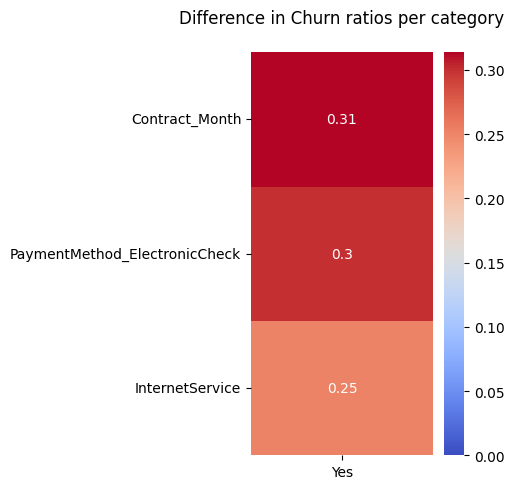

In [86]:
df_churn = dff.melt(value_vars=cols_multi, id_vars='Churn').\
                    groupby(['variable', 'value'])['Churn'].\
                    value_counts(normalize=True).\
                    unstack(level=2).\
                    reset_index()

dff = pd.DataFrame(df_churn.groupby('variable')['Yes'].diff().dropna().abs())
dff.index = df_churn['variable'].unique()

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(dff.sort_values(by='Yes', ascending=False), vmin=0, ax=ax, annot=True, cmap='coolwarm')
ax.set_title('Difference in Churn ratios per category\n')
fig.tight_layout();

In [81]:
df_churn

Churn,variable,value,No,Yes
0,Contract_Month,No,0.966901,0.033099
1,Contract_Month,Yes,0.653188,0.346812
2,InternetService,No,0.925028,0.074972
3,InternetService,Yes,0.673222,0.326778
4,PaymentMethod_ElectronicCheck,No,0.829496,0.170504
5,PaymentMethod_ElectronicCheck,Yes,0.529330,0.470670


## Numeric Data Analyisis

The remaininng variables to analyze are the numeric ones. In this case, they make reference to the Charges and the tenure. There is a close relationship between the Total Charge and the tenure. The longer a customer stays in the company, the more they spend on it.

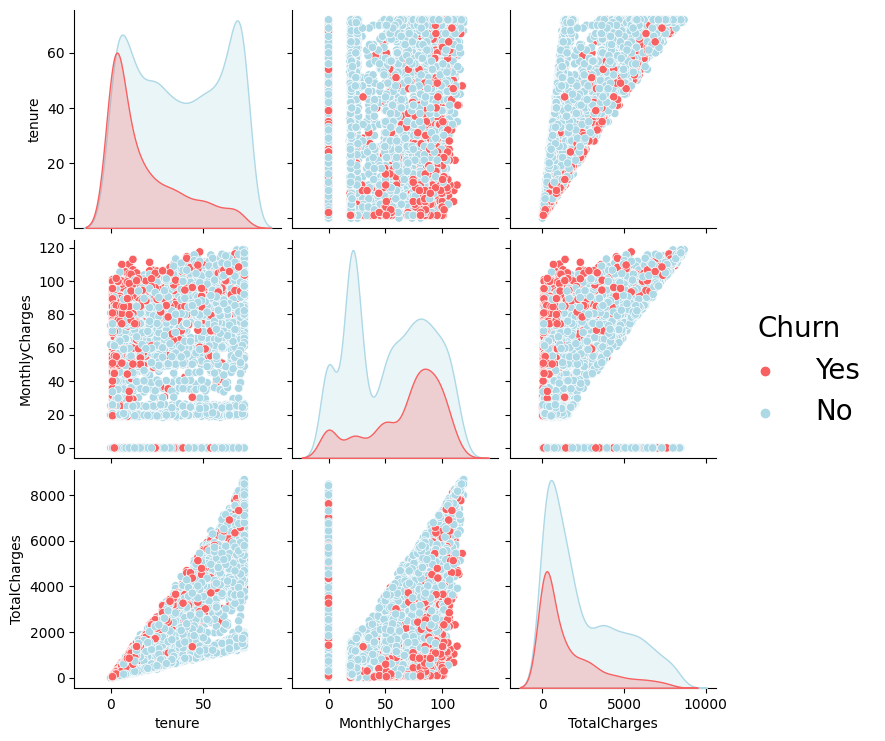

In [25]:
df_num = df[num_data + ['Churn']].copy()
sns.pairplot(df_num, hue='Churn', palette={'Yes':RED, 'No':BLUE});

As we can see in the plot above, there are three conclussions we can obtain about churning people:

- They don't stay for a long time in the company in comparison to the rest.
- They spend considerably more in a monthly basis, probably because they don't pay in a year or 2-years base.
- As they don't stay for a long time, even when they spend more money monthly, their total charges are not very high. 

## Correlations

In this problem we have categorical and numerical data. How can we check correlations with the target?

- Binary and binary -> Cramer's V (In statistics, Cramér's V (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946.)

- Continuous and binary -> Point Biserial (based on Chi Squared test for independency)
- Continuous and continuous -> Pearson Coef

### Categorical

The first step is converting all the categorical variables into dummies so that we have only binary and continuous data and we can apply these methods.

In reality, we could transform all binary features in boolean and multiclass we can split them based on categories.

In [26]:
df_bin_dummy = pd.get_dummies(df_binary, drop_first=True)
df_bin_dummy.columns=[re.sub('_.*$', '', col) for col in df_bin_dummy]
df_bin_dummy

,SeniorCitizen,gender,PaperlessBilling,PhoneService,Churn,Partner,Dependents
0,0,0,1,1,1,1,0
1,0,1,1,1,0,1,1
2,0,1,0,1,0,1,1
3,0,0,1,1,0,1,0
4,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...
4207,0,0,0,1,0,1,1
4208,0,0,1,1,0,0,0
4209,0,1,1,1,0,0,0
4210,0,0,1,1,1,0,0


In [27]:
df_non_binary_dummy = pd.get_dummies(df_non_binary.drop(columns='Churn'))
df_non_binary_dummy

,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,DeviceProtection_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
1,0,0,1,1,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
2,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,1,0,0,1,0,0,0,0,1,1,...,0,1,0,1,0,0,0,0,1,0
4,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4207,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
4208,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
4209,0,0,1,1,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4210,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0


In [28]:
df_cat_dummy = pd.concat([df_bin_dummy, df_non_binary_dummy], axis=1)
df_cat_dummy

,SeniorCitizen,gender,PaperlessBilling,PhoneService,Churn,Partner,Dependents,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,1,1,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
1,0,1,1,1,0,1,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0
2,0,1,0,1,0,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,0,1,1,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
4,0,1,0,1,0,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4207,0,0,0,1,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
4208,0,0,1,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
4209,0,1,1,1,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
4210,0,0,1,1,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0


Let's calculate now their correlations with the target using Cramer's V

In [29]:
d_cramer = {}
for col in df_cat_dummy.columns:
    if col != 'Churn':
        d_cramer[col] = [cramersv(df_cat_dummy, col, 'Churn')]

df_cramer = pd.DataFrame(d_cramer, index=['Correlations']).T.sort_values(by='Correlations', ascending=False)
df_cramer.head()

,Correlations
Contract_Month-to-month,0.405564
TechSupport_No,0.343628
OnlineSecurity_No,0.339402
PaymentMethod_Electronic check,0.319331
Contract_Two year,0.299471


(<Figure size 5000x3000 with 1 Axes>,
 <AxesSubplot: title={'center': "Top Cramer's V Correlations\n"}, xlabel='Correlations'>)

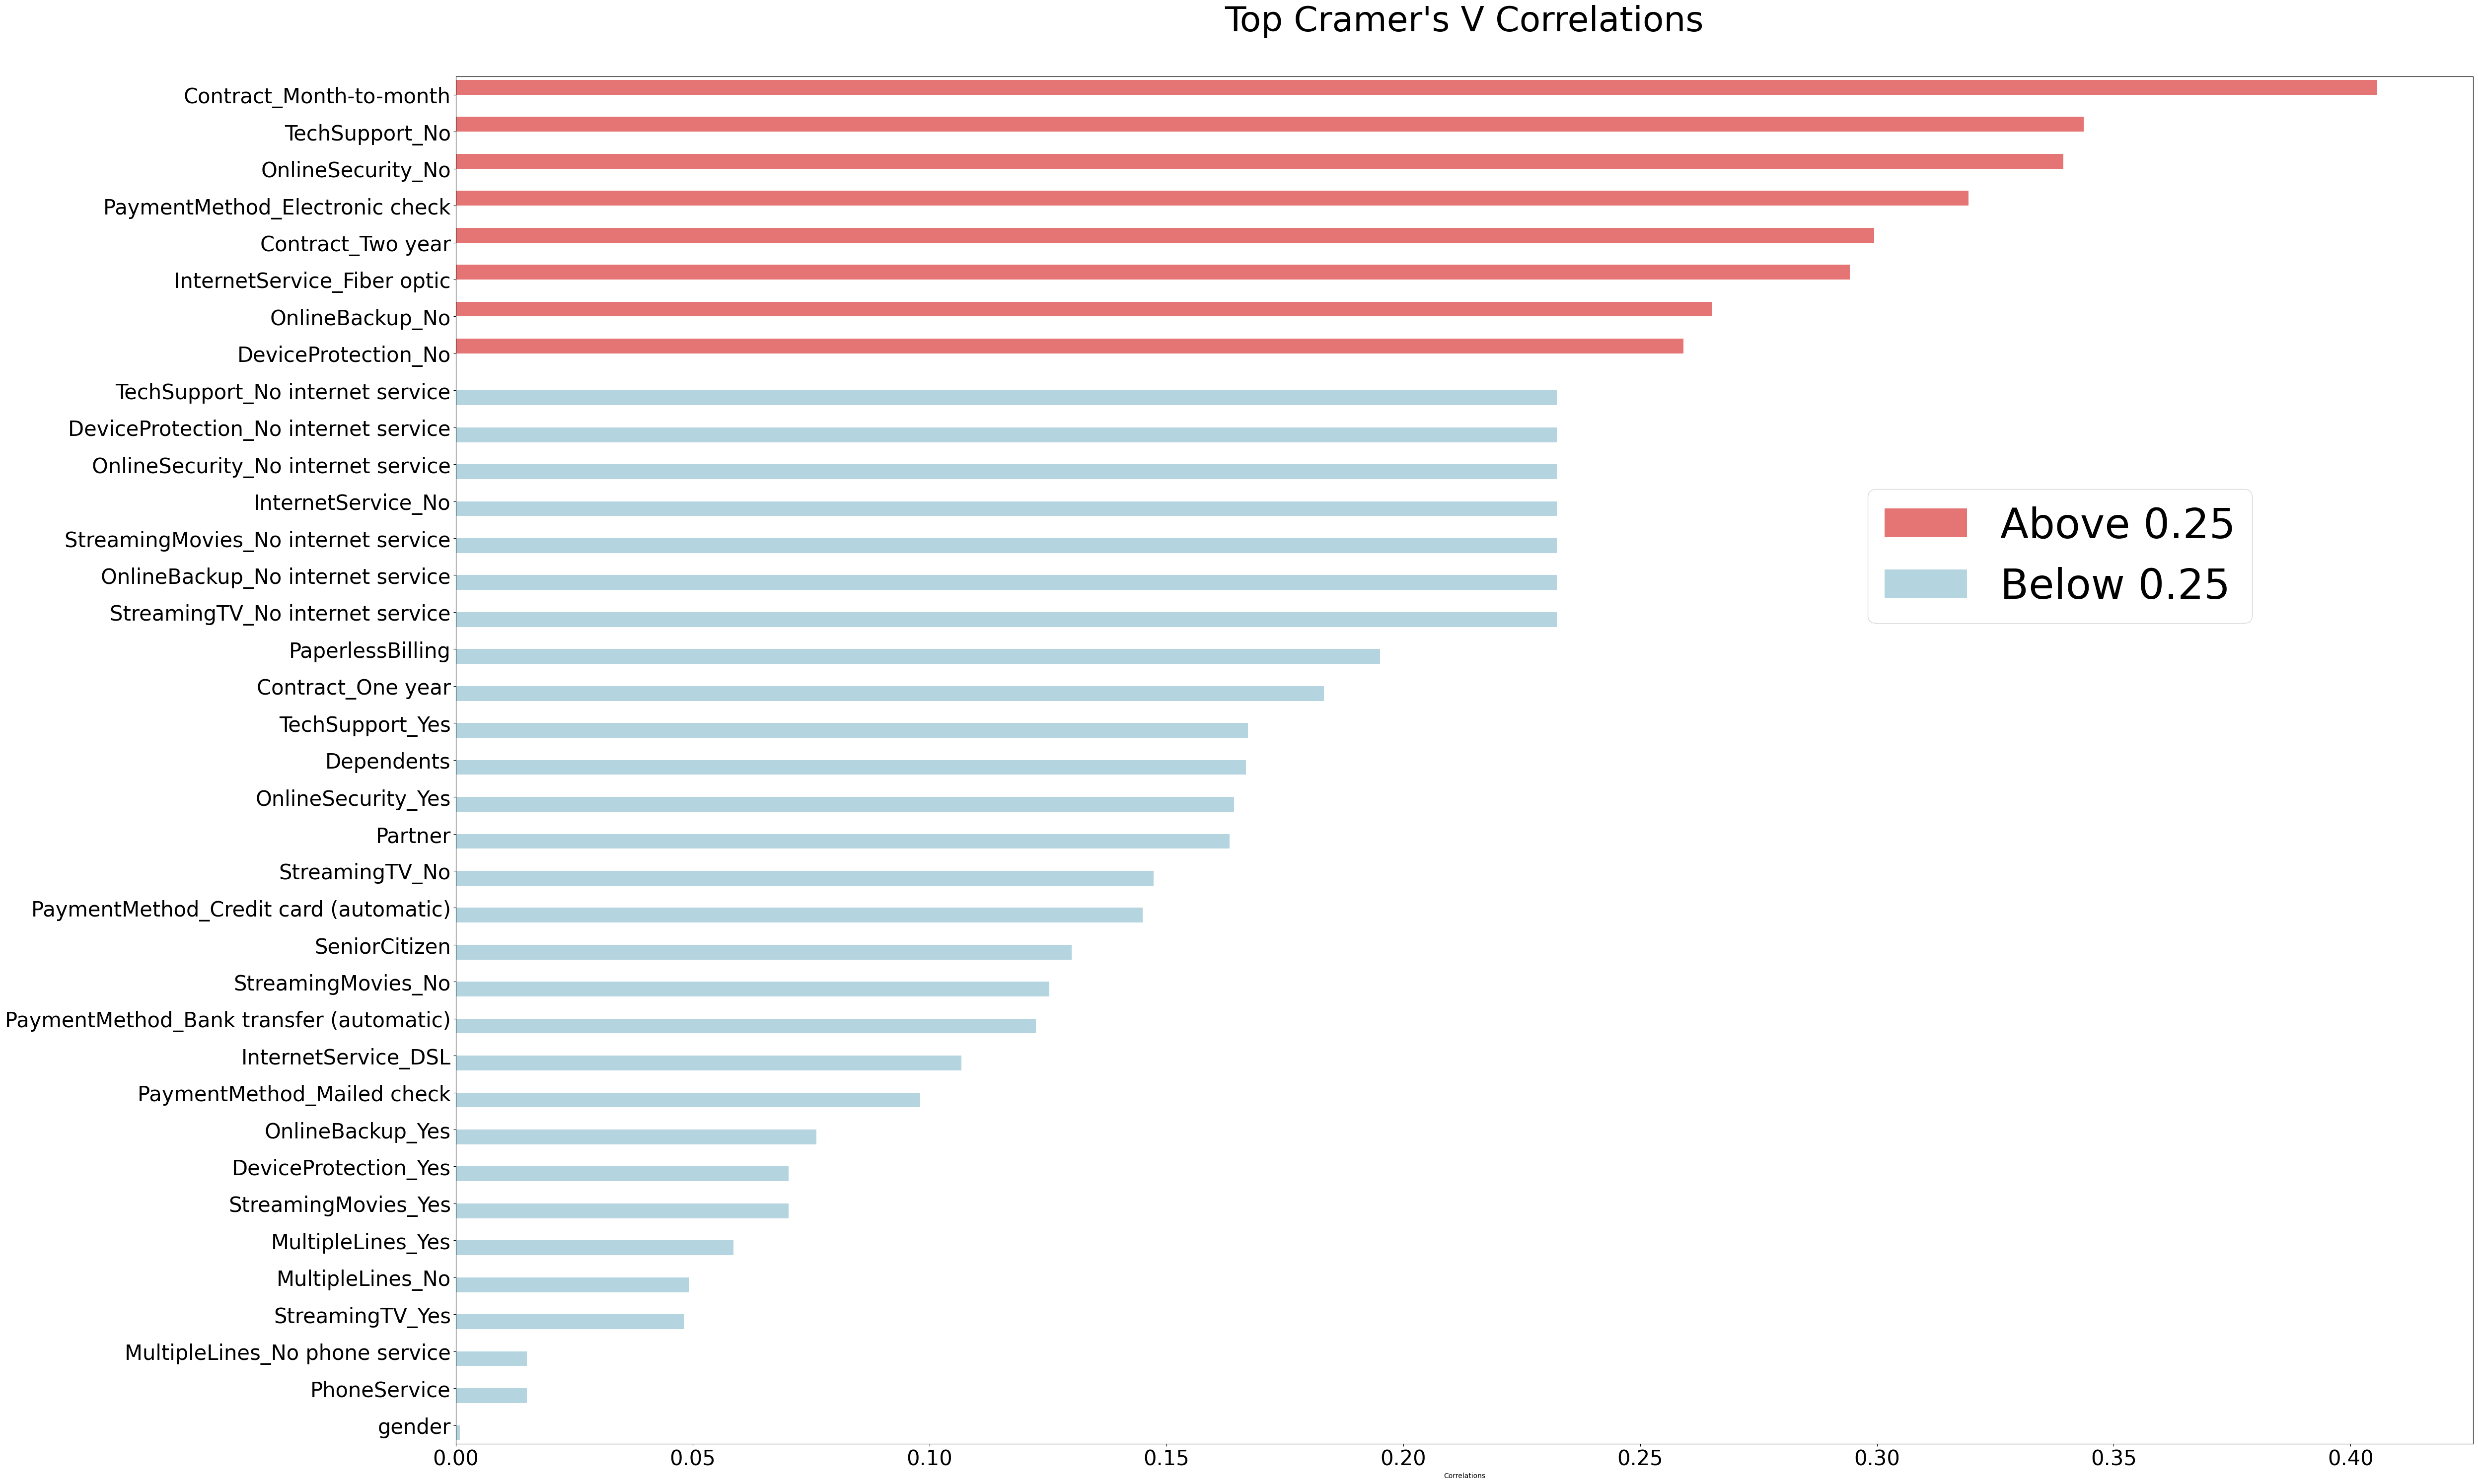

In [37]:
plot_corr(df_cramer, method='Cramer\'s V')

Cramer's V only tells us the strength of the correlation. We can calculate Pearson's coefficient too. This isn't totally correct when we deal with categorical data but if results are similar we can assume that signs are correct.

(<AxesSubplot: title={'center': 'Top Pearson Correlations\n'}, xlabel='Correlations'>,
 <Figure size 5000x3000 with 1 Axes>)

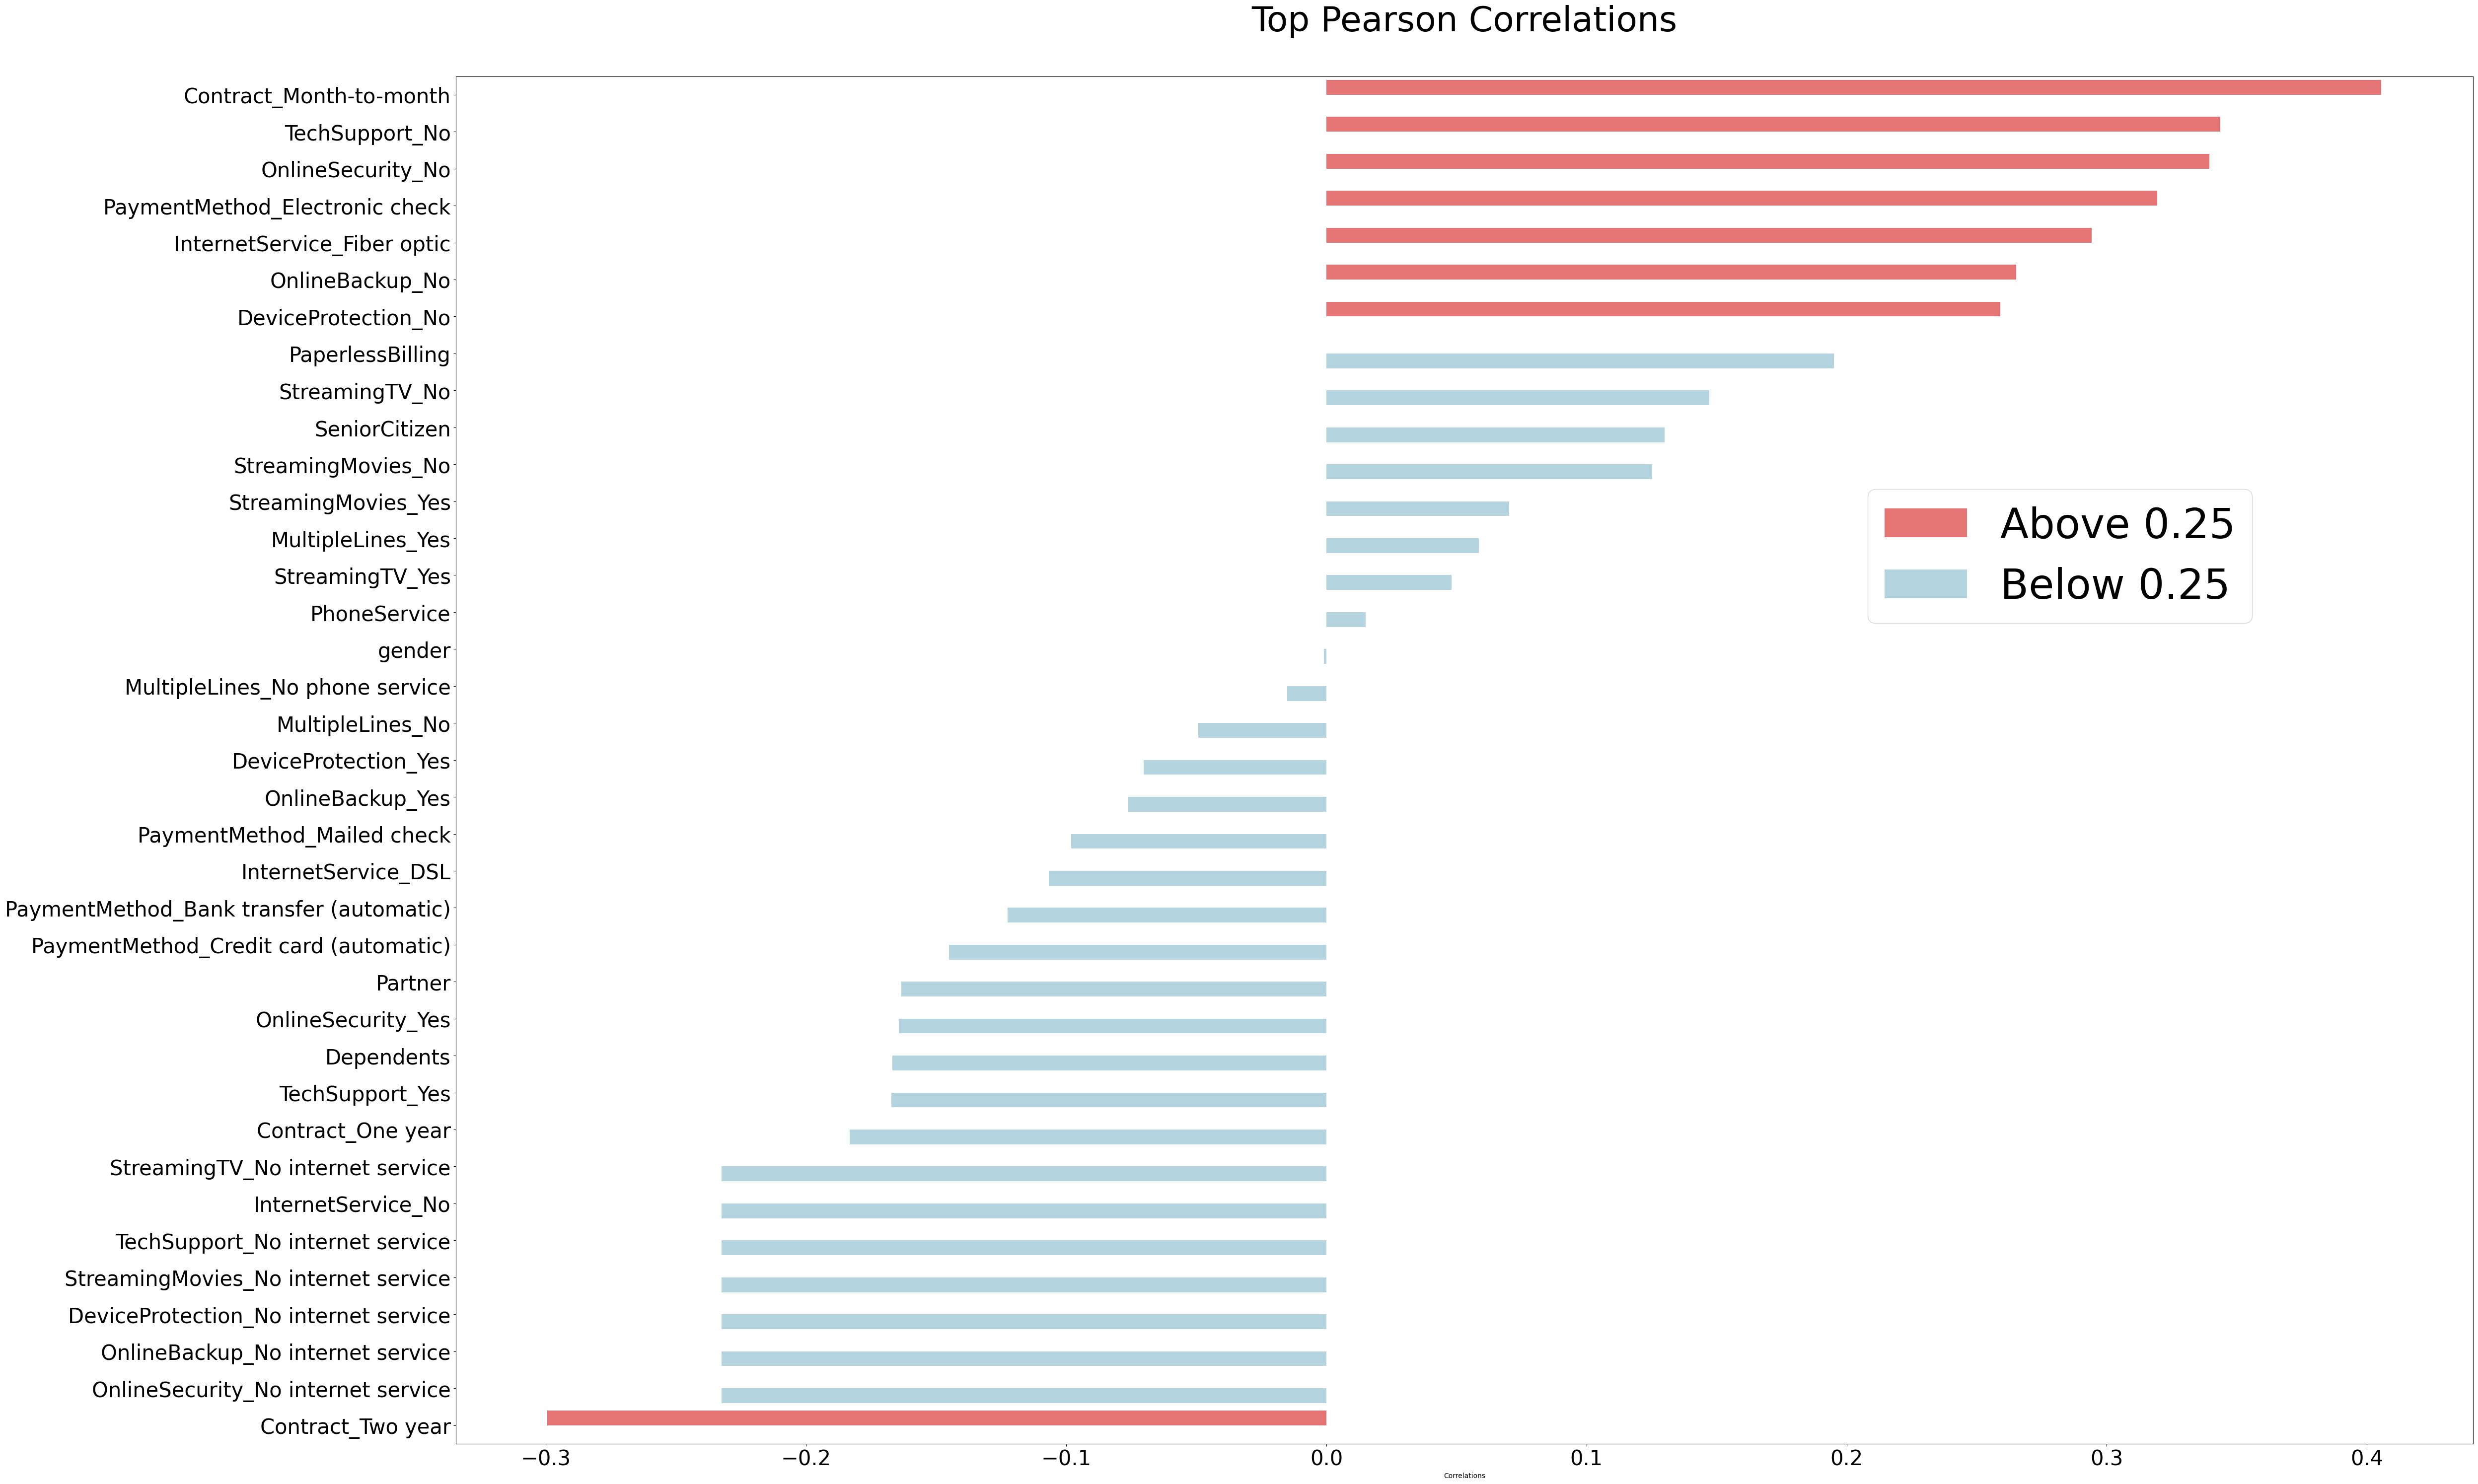

In [32]:
pearson_cat = pd.DataFrame(df_cat_dummy.corr()['Churn'].drop('Churn').sort_values(ascending=False))
pearson_cat.columns = ['Correlations']
plot_corr(pearson_cat, method='Pearson')

We can see that in this case, Pearson correlations and Cramer's V are coincident in absolute values. We can accept then that the signs are correct too then so, correlations tell us something similar to what plots showed right before:

There's a strong relationship between Churn and:

- Not having any kind of insurance or security product (OnlineSecurity, TechSupport, OnlineBackup, DeviceProtection,...)
- Having a monthly contract instead a yearly or two yearly one. The last one is specially related to staying in the company.

### Numerical

In this case we calculate both biserial and Pearson's correlations. The results are identical.

The conclusions we obtain here fit perfectly with what was shown before. The most important one is the **negative correlation between long permanence contracts and Churn**.

In [68]:
df_num_tar = pd.concat([df_num.drop(columns='Churn'), df_cat_dummy['Churn']], axis=1)
df_num_tar.head()

,tenure,MonthlyCharges,TotalCharges,Churn
0,11,102.00,1145.35,1
1,66,0.00,4189.70,0
2,71,19.45,1378.45,0
3,31,64.00,1910.75,0
4,62,0.00,5215.25,0


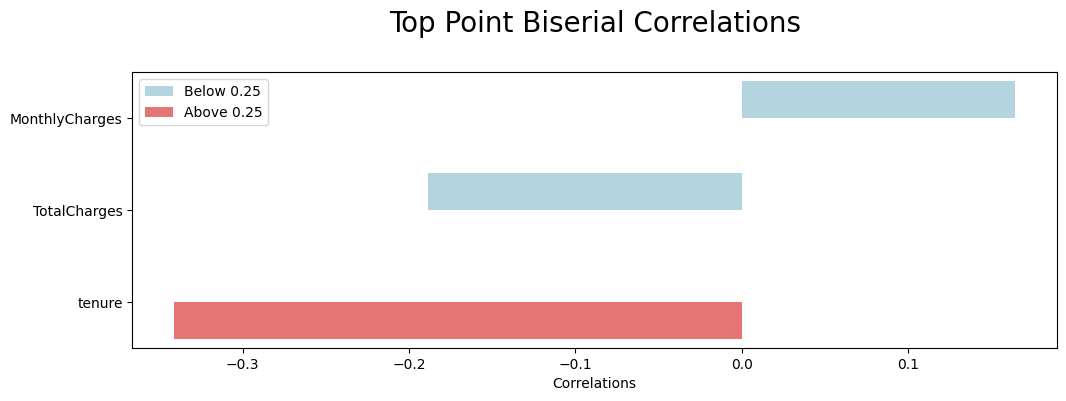

In [69]:
d_pbs = {}
for col in df_num.columns:
    if col!='Churn':
        d_pbs[col] = [stats.pointbiserialr(df_num_tar[col].fillna(0), df_num_tar['Churn']).correlation]

df_pbs = pd.DataFrame(d_pbs).T.sort_values(by=0,ascending=False)
df_pbs.columns=['Correlations']

fig, ax = plot_corr(df_pbs, method='Point Biserial')
fig.set_size_inches(10, 3)
ax.set_title(ax.get_title(), fontsize=20)
ax.legend(fontsize=10)
ax.tick_params('both', labelsize=10);

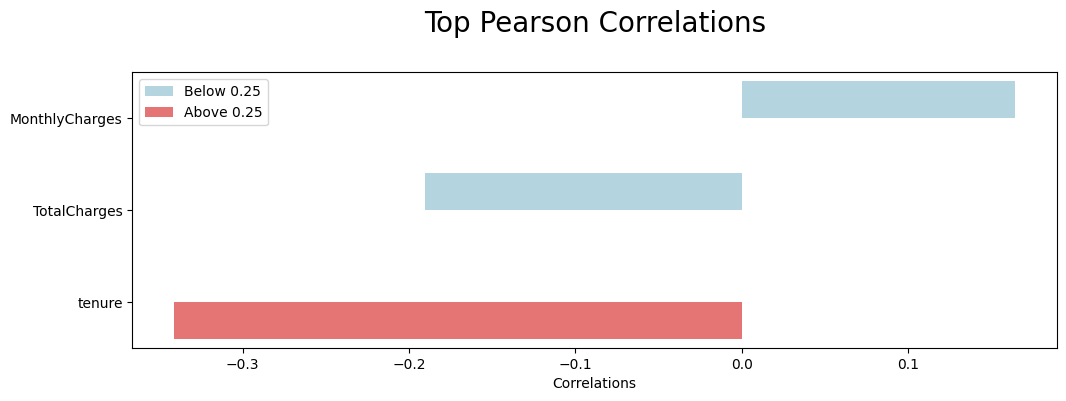

In [70]:
pearson_cat = pd.DataFrame(df_num_tar.corr()['Churn'].drop('Churn').sort_values(ascending=False))
pearson_cat.columns = ['Correlations']


fig, ax = plot_corr(pearson_cat, method='Pearson')
fig.set_size_inches(10, 3)
ax.set_title(ax.get_title(), fontsize=20)
ax.legend(fontsize=10)
ax.tick_params('both', labelsize=10);

### Colinearities

Let's have a look at the colinearities between the features. In this case we could proceed the same way we have done it before, separating categoricals and numericals but for simplicity we decide to use Pearson correlation factor for all of them.

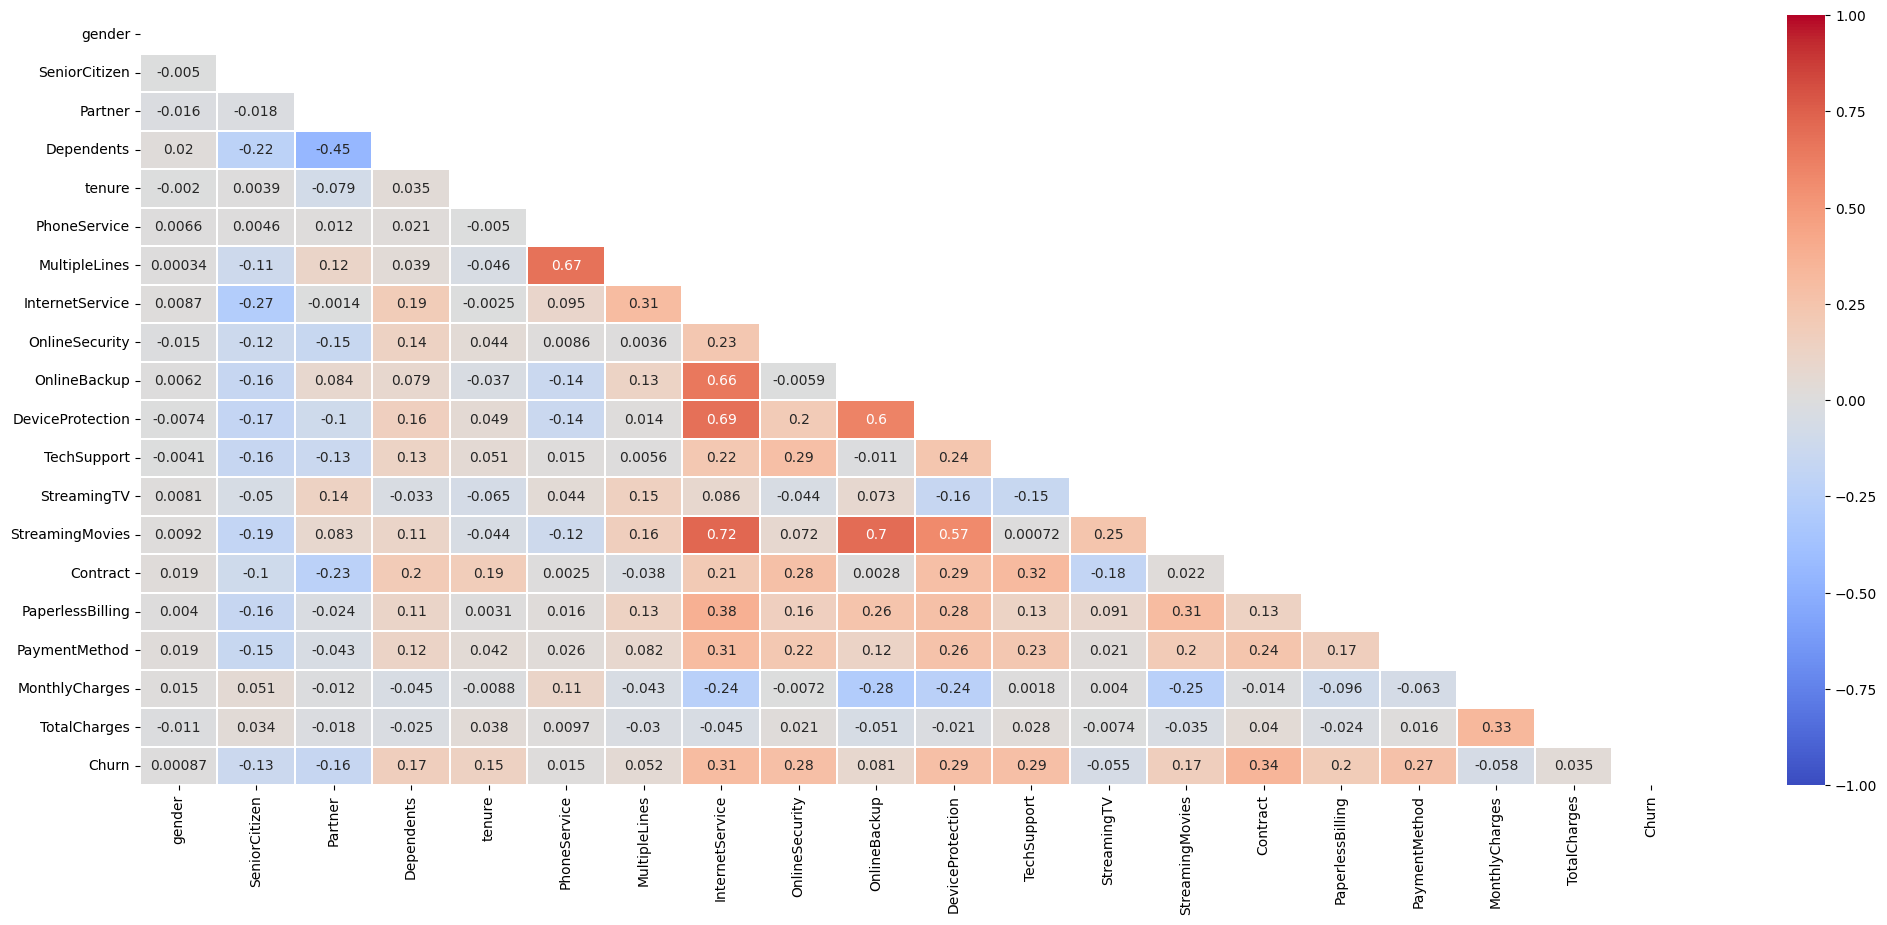

In [98]:
plt.figure(figsize=(25, 10))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.title()